In [9]:
from datetime import datetime
import itertools
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
plt.style.use('fivethirtyeight')

In [10]:
from iexfinance.stocks import get_historical_data
def get_iex_data(stock_list, start=datetime(2015,1,1), end=datetime(2019,12,31)):
    return_list = []
    for i in stock_list:
        df = pd.DataFrame(get_historical_data(i, start, end, output_format='pandas', token='pk_d28c0190de7a4d6da30b3bd2b08487c8'))
        df['ticker'] = i
        return_list.append(df)
    return return_list

## Import Data

In [11]:
hun_etfs = ['SPLV']
data = get_iex_data(hun_etfs)

In [12]:
splv = data[0]
splv.to_csv('splv.csv', encoding='utf-8')

In [13]:
def clean_data(data):
    for i in range(len(data)):
        data[i] = data[i].reset_index()
        data[i]['date'] = pd.to_datetime(data[i]['date'])
        data[i] = data[i].set_index('date')
    return data

In [14]:
data = clean_data(data)

In [15]:
# data

In [16]:
ts = data[0]['close']

## ARIMA analysis

In [17]:
# p = d = q = range(0,3)
# pdq = list(itertools.product(p,d,q))
# pdqs = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(ts,
#                                             order=comb,
#                                             seasonal_order=combs,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {} : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue    

In [18]:
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# ans_df.loc[ans_df['aic'].idxmin()]

In [19]:
ARIMA_model = sm.tsa.statespace.SARIMAX(ts,
                                order=(2, 2, 2),
                                seasonal_order=(0, 0, 2, 5),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
output = ARIMA_model.fit()
print(output.summary().tables[1])


C:\Users\jayar\anaconda\Anaconda3\envs\PandaSpace\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8295      0.089     -9.307      0.000      -1.004      -0.655
ar.L2         -0.0898      0.020     -4.452      0.000      -0.129      -0.050
ma.L1         -0.1960      2.396     -0.082      0.935      -4.892       4.500
ma.L2         -0.8040      1.925     -0.418      0.676      -4.576       2.968
ma.S.L5        0.0102      0.024      0.428      0.669      -0.036       0.057
ma.S.L10      -0.0162      0.025     -0.649      0.516      -0.065       0.033
sigma2         0.0967      0.231      0.418      0.676      -0.357       0.550


In [20]:
csv_output = output.summary().tables[1]

summary_df = pd.DataFrame(csv_output, index=None)
# csv_output.to_csv('spy_summary.csv', encoding='utf-8')
# csv_output
summary_df.columns = summary_df.iloc[0]
summary_df = summary_df[1:]

summary_df.to_csv('splv_summary.csv', encoding='utf-8')
summary_df


,,coef,std err,z,P>|z|,[0.025,0.975]
1,ar.L1,-0.8295,0.089,-9.307,0.000,-1.004,-0.655
2,ar.L2,-0.0898,0.020,-4.452,0.000,-0.129,-0.050
3,ma.L1,-0.1960,2.396,-0.082,0.935,-4.892,4.500
4,ma.L2,-0.8040,1.925,-0.418,0.676,-4.576,2.968
5,ma.S.L5,0.0102,0.024,0.428,0.669,-0.036,0.057
6,ma.S.L10,-0.0162,0.025,-0.649,0.516,-0.065,0.033
7,sigma2,0.0967,0.231,0.418,0.676,-0.357,0.550


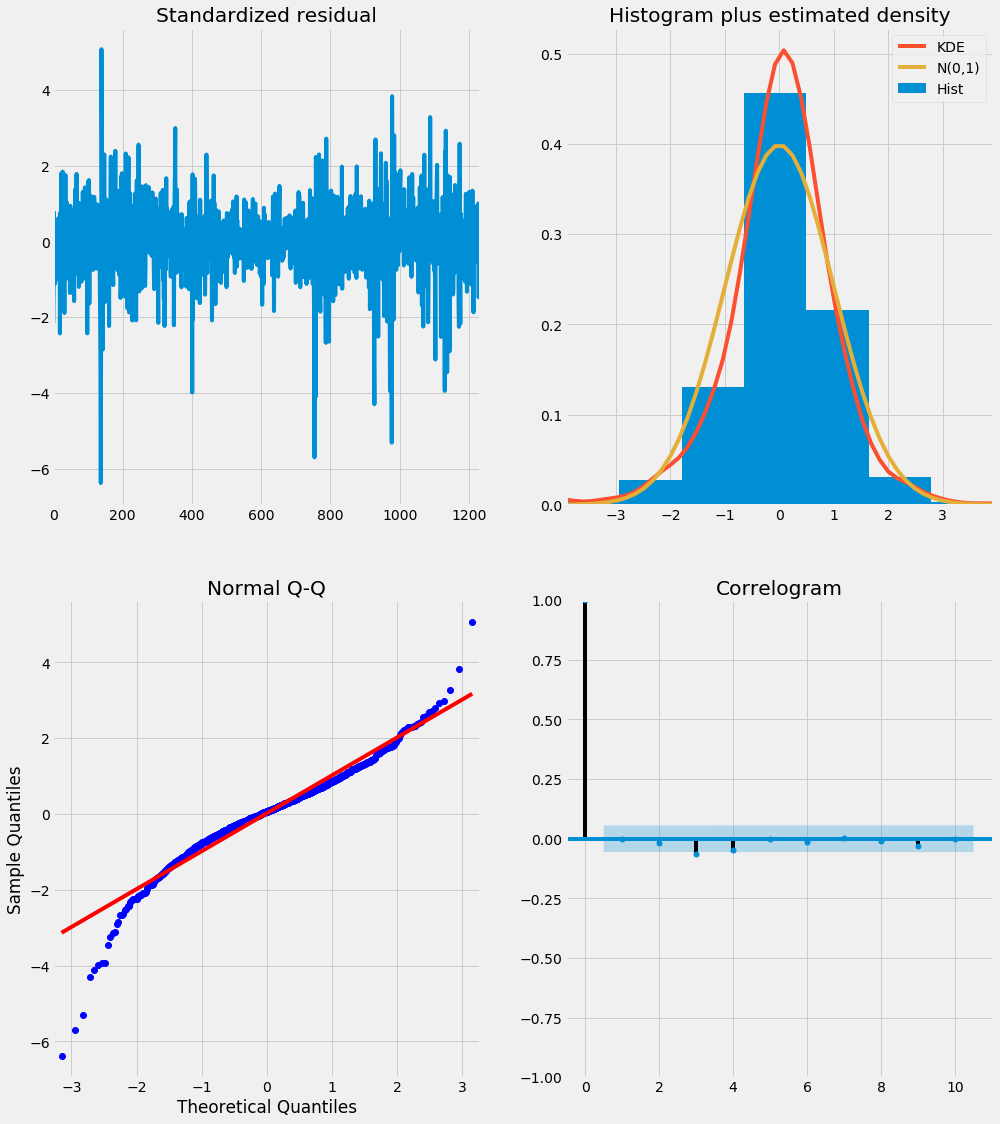

In [21]:
output.plot_diagnostics(figsize=(15, 18))
plt.savefig('splvoutput.png')
plt.show()

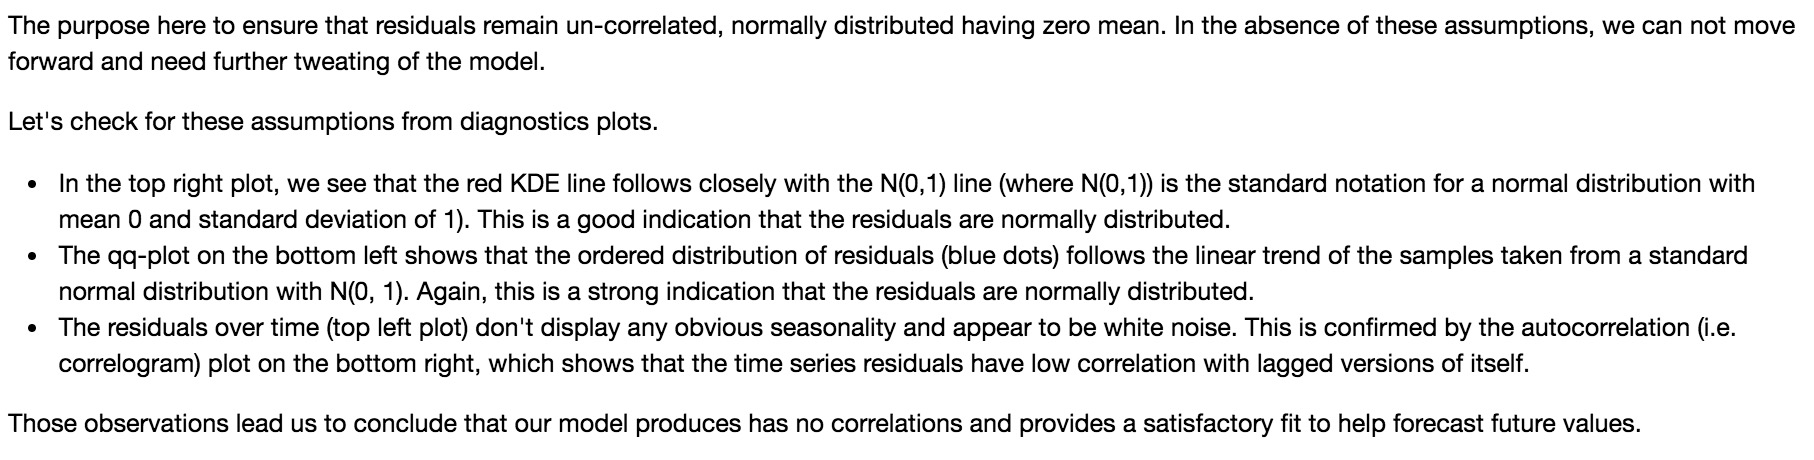

In [22]:
# plt.savefig('arima1.png')

In [23]:
pred = output.get_prediction(start=pd.to_datetime('2019-11-01'), dynamic=False)
pred_conf = pred.conf_int()

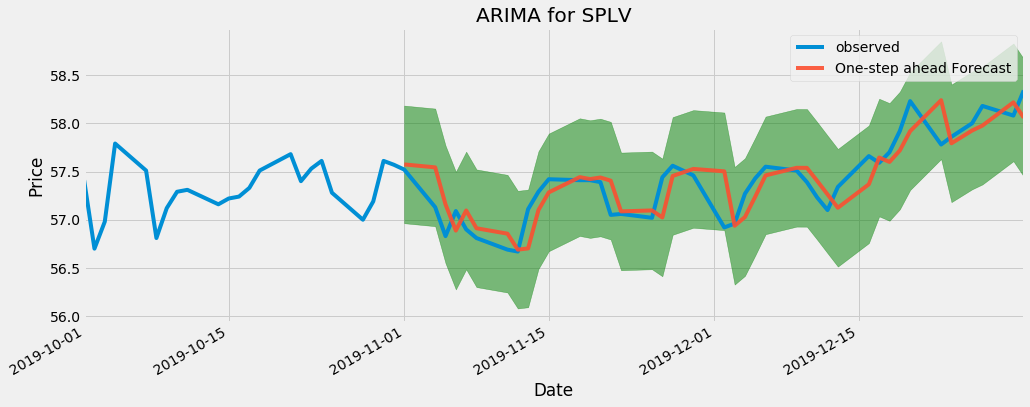

In [24]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = ts['2019-10':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
plt.title('ARIMA for SPLV')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.savefig('splv_arima.png')
plt.show()

In [25]:
price_forecasted = pred.predicted_mean
price_truth = ts['2019-11-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.05


In [26]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-11-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

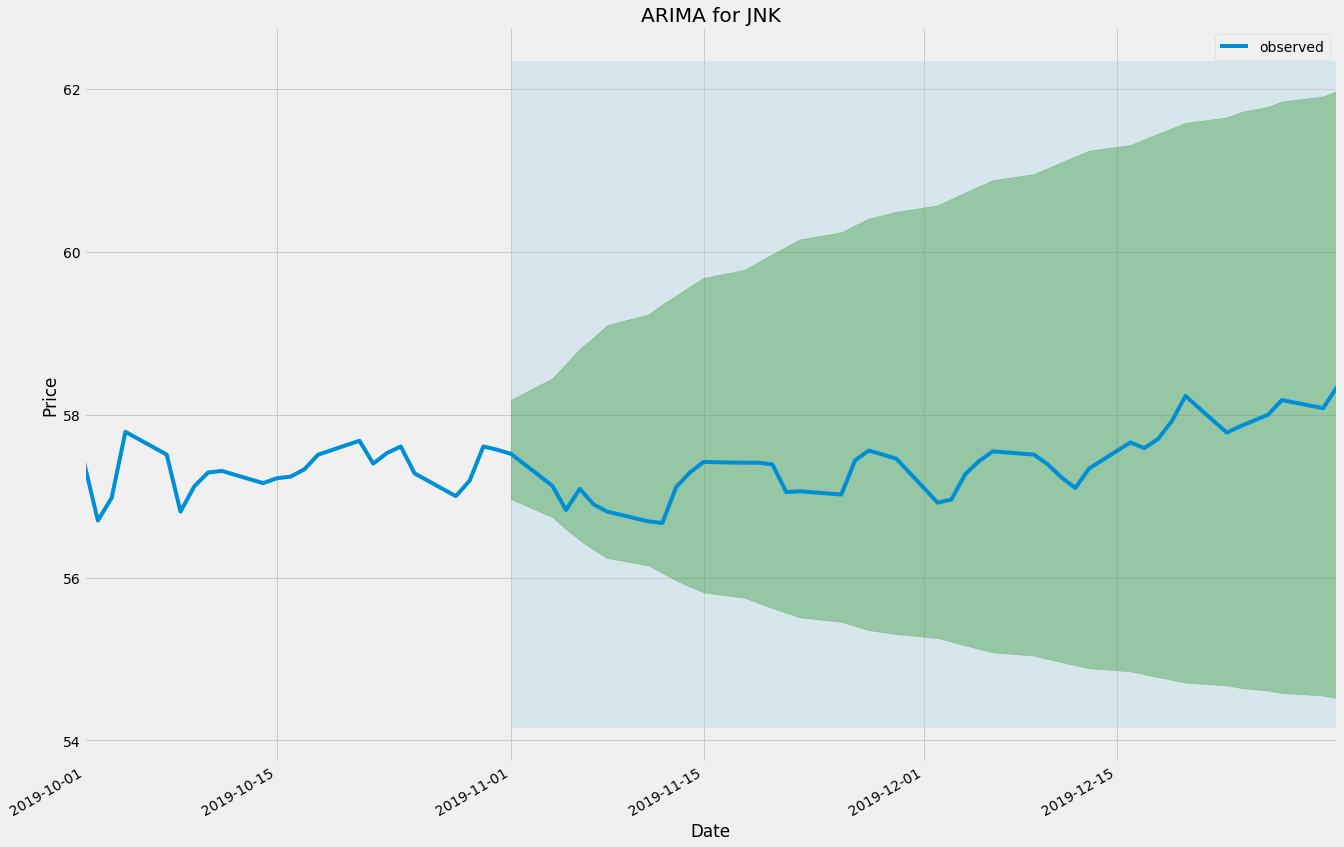

In [27]:
ax = ts['2019-10':].plot(label='observed', figsize=(20, 15))
# datum.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-11-01'), price_forecasted.index[-1], alpha=.1, zorder=-1)

plt.title('ARIMA for JNK')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.savefig('splv_arima2.png')
plt.show()

In [28]:
price_forecasted = pred_dynamic.predicted_mean
price_truth = ts['2019-11-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.35


In [29]:
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

C:\Users\jayar\anaconda\Anaconda3\envs\PandaSpace\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



## FBProphet for Future

In [30]:
from fbprophet import Prophet as proph
spy = pd.DataFrame(data[0]['close']).reset_index()
spy.columns = ['ds', 'y']

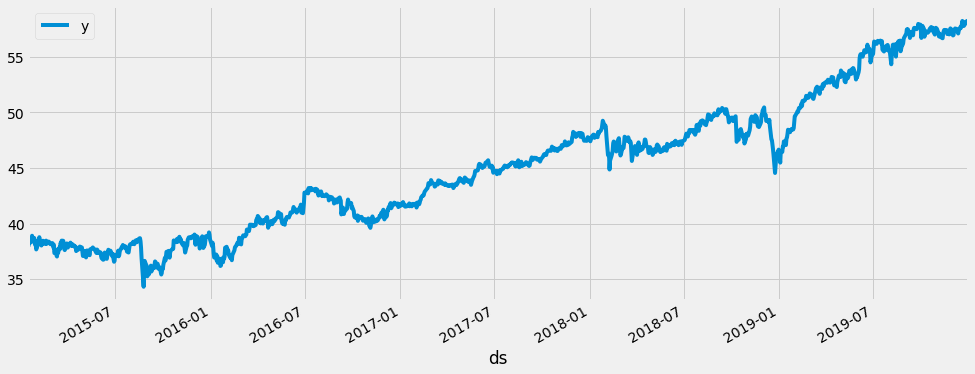

In [31]:
spy.set_index('ds').plot()

In [32]:
p = proph(interval_width=.95)
p.fit(spy)
inp = p.make_future_dataframe(periods=30, freq='D')
out = p.predict(inp)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\jayar\anaconda\Anaconda3\envs\PandaSpace\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [33]:
df = out[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [34]:
spy_df_novjan = df.tail(71)
spy_df_novjan.dtypes

ds            datetime64[ns]
yhat                 float64
yhat_lower           float64
yhat_upper           float64
dtype: object

In [27]:
# def get_iex_data(stock_list, start=datetime(2019,11,1), end=datetime(2020,1,10)):
#     return_list = []
#     for i in stock_list:
#         df = pd.DataFrame(get_historical_data(i, start, end, output_format='pandas', token='pk_d28c0190de7a4d6da30b3bd2b08487c8'))
#         df['ticker'] = i
#         return_list.append(df)
#     return return_list
# etf = ['VV']
# data = get_iex_data(etf)
# pull = data[0]['close']
# pull_df = pd.DataFrame(pull)

In [28]:
# pull_df

In [35]:
spy_yf = pd.read_csv('SPLV_yf.csv')
spy_yf = spy_yf.rename(columns={"Date": "ds"})
spy_yf['ds'] = pd.to_datetime(spy_yf['ds'])

spy_yf.dtypes

ds           datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [36]:
spy_yf1 = spy_yf[['ds','Adj Close']]
spy_yf1

,ds,Adj Close
0,2019-11-01,57.303371
1,2019-11-04,56.914841
2,2019-11-05,56.615974
3,2019-11-06,56.874992
4,2019-11-07,56.685707
5,2019-11-08,56.596046
6,2019-11-11,56.476498
7,2019-11-12,56.456573
8,2019-11-13,56.894917
9,2019-11-14,57.074238


In [37]:
comb = spy_df_novjan.join(spy_yf1.set_index('ds'), on='ds')
# comb = comb.set_index('ds')
comb['difference'] = comb['Adj Close'] - comb['yhat']
comb['difference_pct'] = comb['difference']/comb['Adj Close']
comb['difference_pct'] = comb['difference_pct'].map("{:.2%}".format)
comb.to_csv('splv_predict_fbprophet.csv', encoding='utf-8')
comb = comb.drop([1249])
comb = comb.drop([1252])
comb = comb.drop([1253])
comb = comb.drop([1259])
comb = comb.drop([1260])
comb = comb.drop([1266])
comb = comb.drop([1267])
comb = comb.drop([1268])
comb = comb.drop([1273])
comb = comb.drop([1274])
comb.tail(50)

,ds,yhat,yhat_lower,yhat_upper,Adj Close,difference,difference_pct
1219,2019-11-18,57.461520,56.318525,58.650638,57.300564,-0.160956,-0.28%
1220,2019-11-19,57.531125,56.367766,58.688081,57.300564,-0.230561,-0.40%
1221,2019-11-20,57.551769,56.411044,58.717921,57.280602,-0.271167,-0.47%
1222,2019-11-21,57.627367,56.479112,58.831680,56.941250,-0.686117,-1.20%
1223,2019-11-22,57.679264,56.507630,58.878655,56.951233,-0.728031,-1.28%
1224,2019-11-25,57.754516,56.523757,58.889831,56.911308,-0.843208,-1.48%
1225,2019-11-26,57.829625,56.639518,58.957616,57.330505,-0.499120,-0.87%
1226,2019-11-27,57.853346,56.661887,58.930216,57.450279,-0.403067,-0.70%
1227,2019-11-29,57.978738,56.796483,59.092038,57.350468,-0.628270,-1.10%
1228,2019-12-02,58.027920,56.873141,59.178902,56.811497,-1.216423,-2.14%


In [7]:
comb = pd.read_csv('splv_predict_fbprophet.csv')
comb.tail(41)

,Unnamed: 0,ds,yhat,yhat_lower,yhat_upper,Adj Close,difference,difference_pct
20,1231,12/2/2019,58.049351,56.879377,59.126700,56.811497,-1.237854,-2.18%
21,1232,12/3/2019,58.108191,56.917074,59.258178,56.851421,-1.256770,-2.21%
22,1233,12/4/2019,58.113258,57.009610,59.295136,57.160831,-0.952427,-1.67%
23,1234,12/5/2019,58.167889,57.009785,59.345101,57.320526,-0.847363,-1.48%
24,1235,12/6/2019,58.193700,57.017558,59.239734,57.440296,-0.753404,-1.31%
25,1236,12/9/2019,58.156799,56.963821,59.349262,57.400372,-0.756427,-1.32%
26,1237,12/10/2019,58.184927,57.016605,59.413643,57.280602,-0.904325,-1.58%
27,1238,12/11/2019,58.158660,56.956557,59.281232,57.120907,-1.037753,-1.82%
28,1239,12/12/2019,58.181859,56.939248,59.294668,56.991154,-1.190705,-2.09%
29,1240,12/13/2019,58.176676,57.014055,59.325035,57.230698,-0.945978,-1.65%


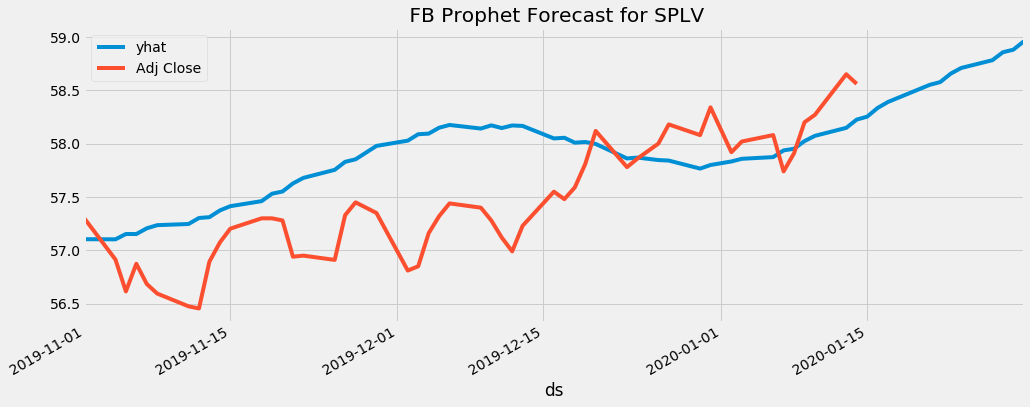

In [38]:
comb.plot(x="ds", y=["yhat", "Adj Close"], kind="line")
plt.title(' FB Prophet Forecast for SPLV')
plt.savefig('splv_fbproph_forecast.png')

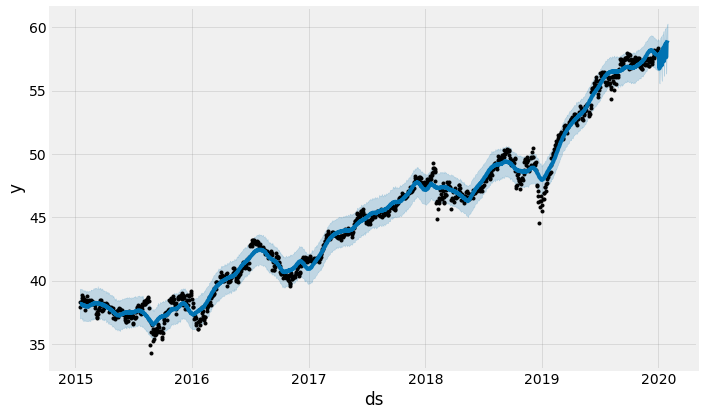

In [39]:
p.plot(df)
plt.savefig('splv_fbp2.png')

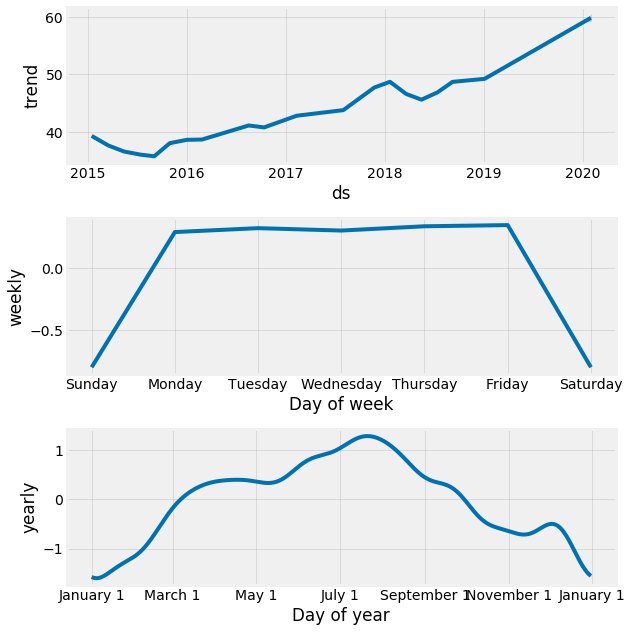

In [40]:
p.plot_components(out)
plt.savefig('splv_seasonality.png')

In [29]:
split = pd.to_datetime('2019-12-01')
true = spy.set_index('ds')[split:]
past = spy.set_index('ds')[:split].reset_index()

In [30]:
pro = proph(interval_width=.95)
pro.fit(past)
inp = pro.make_future_dataframe(periods=20, freq='D').set_index('ds')[split:].reset_index()
out = pro.predict(inp)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
pred = out[['ds', 'yhat']].set_index('ds')